In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install pyarrow
!pip install scikit-learn

In [190]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# ETL Pipeline and Feature Engineering
As mentioned before, the model will be trained to predict data from sensor LIT101, so this along with the timestamps will be the only useful information to keep.

Load data.

In [191]:
train = pd.read_csv('data-raw/train.csv', delimiter = ',', skipinitialspace = True)
test = pd.read_csv('data-raw/test.csv', delimiter = ',', skipinitialspace = True)
test_labels = pd.read_csv('data-raw/test_labels.csv', delimiter = ',', skipinitialspace = True)

Convert timestamps to datetime.

In [192]:
train['Timestamp'] = pd.to_datetime(train['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
test['Timestamp'] = pd.to_datetime(test['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

Remove the data before 2015-12-23 as it shows sensor initialization.

In [193]:
train = train[train['Timestamp'] > '2015-12-23']

As mentioned in the data exploration part, only sensor LIT101 will be used.
Eliminate information from all the other sensors. Create a new df for train labels and make the labels all 0 (normal behavior).

In [194]:
y_train = train[['Normal/Attack']].reset_index().drop('index', axis = 1)
y_train.rename(columns={'Normal/Attack': 'Label'}, inplace=True)
y_train['Label'] = y_train['Label'].apply(lambda x: 0 if x == 'Normal' else 1)

x_train = train[['LIT101']]

Do the same for the test data, but remove the 'Normal/Attack' column as it does not contribute any information.

In [200]:
x_test = test[['LIT101']]
y_test = test_labels
y_test.rename(columns={'Normal/Attack': 'Label'}, inplace=True)
y_test['Label'] = y_test['Label'].apply(lambda x: 0 if x == 'Normal' else 1)

Normalise the sensor value columns by applying min-max scaling.

In [201]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [202]:
x_train = scaler.fit_transform(np.float64(x_train))
x_test = scaler.transform(np.float64(x_test))

In [203]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Batch-size and dataset sizes

We will reduce the sensor sampling rate for both the training and test sets as there are too many datapoints, and we can do this without loosing much information. We will take measurements every 10 seconds now.

In [204]:
reduce_sampling_rate = 10

x_train = x_train[np.arange(0, len(x_train), reduce_sampling_rate)]
x_test = x_test[np.arange(0, len(x_test), reduce_sampling_rate)]

y_train = y_train[np.arange(0, len(y_train), reduce_sampling_rate)]
y_test = y_test[np.arange(0, len(y_test), reduce_sampling_rate)]

Great, now our train and test sets have to be divisible by our batch size, and we have to decide on the number of timesteps to use.

A batch size of 64 will be used as it is good practice.

In [205]:
batch_size = 64

In [206]:
print(len(x_train), len(y_train), len(x_test), len(y_test))

46797 46797 44992 44992


As none are divisible by 64, we need to tweak them. 

In [207]:
def trim_data(data, batch_size = batch_size):
    if(len(data) % batch_size == 0):
        return data
    modulo = len(data) % batch_size
    data = data[:len(data) - modulo]
    return data

In [208]:
x_train = trim_data(x_train)
x_test = trim_data(x_test)
y_train = trim_data(y_train)
y_test = trim_data(y_test)

In [209]:
print(len(x_train), len(y_train), len(x_test), len(y_test))

46784 46784 44992 44992


Great, now all of them are divisible by 64.

# Visualization of new data

In [210]:
def visualize(df):
    plt.figure(figsize=(15, 8))
    plt.plot(df, label='LIT101')
    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

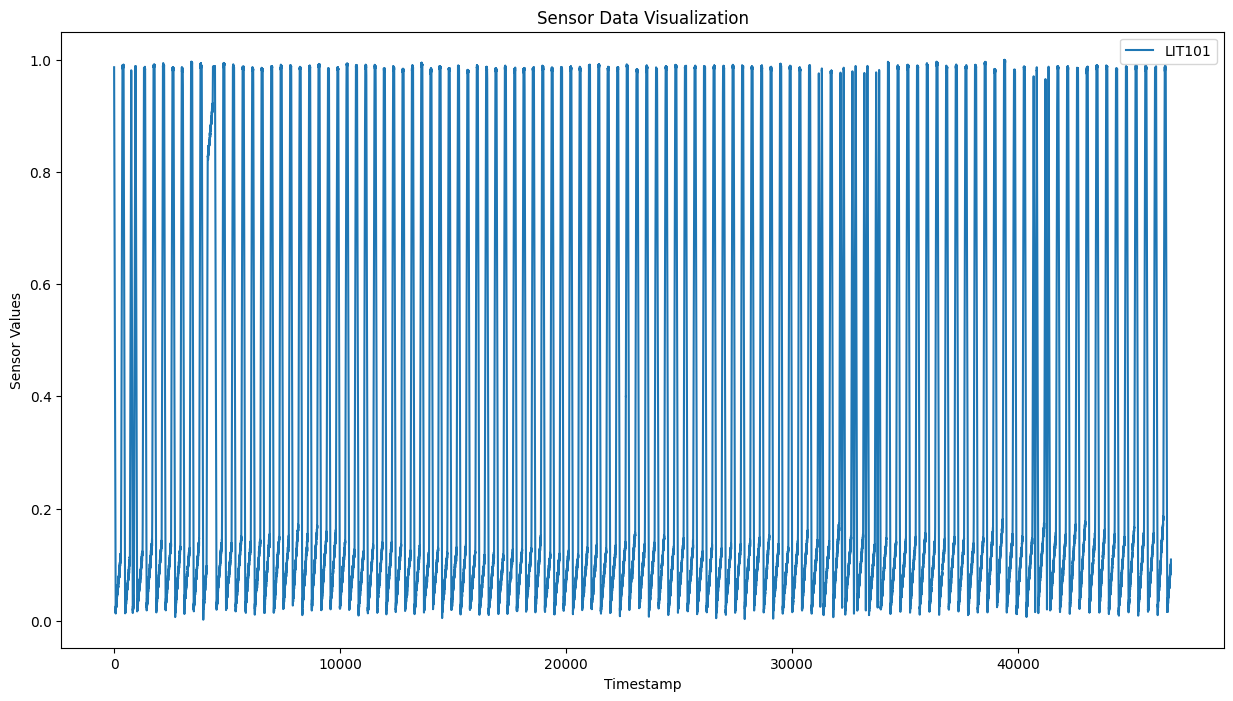

In [211]:
visualize(x_train)

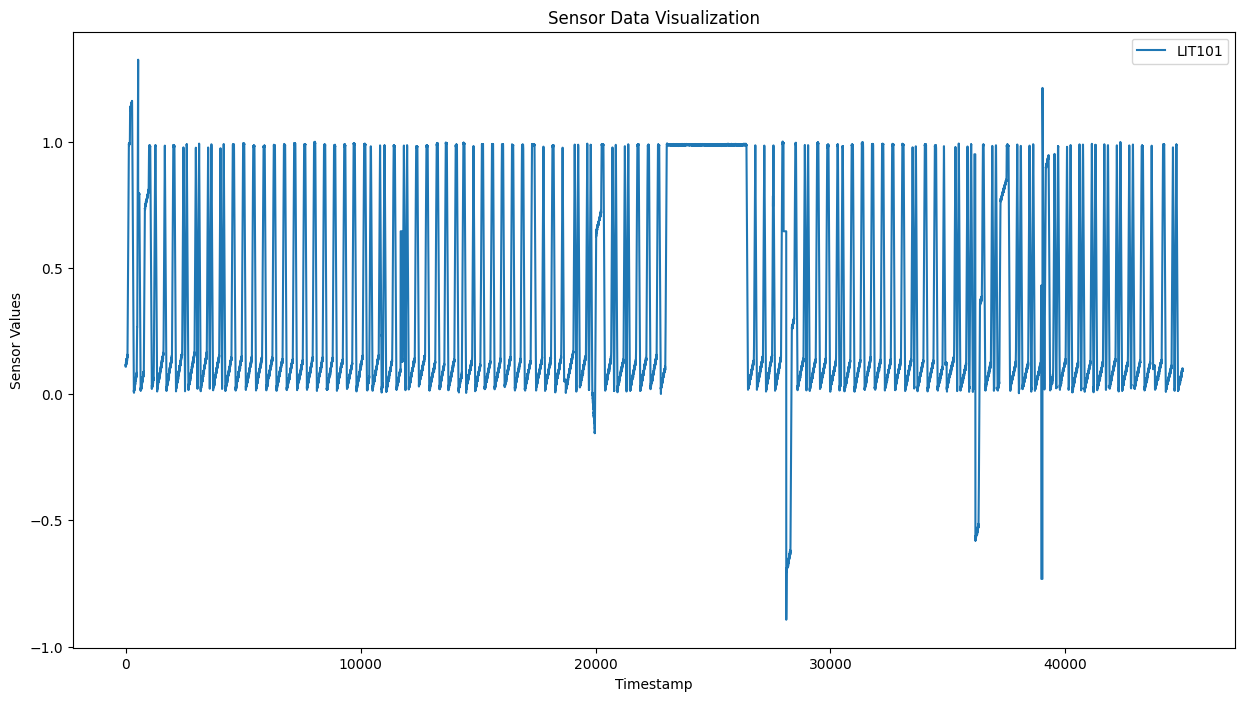

In [212]:
visualize(x_test)

Data is now ready to be exported into new csv files.

In [214]:
np.savetxt('data-etl/x_train.csv', x_train, delimiter = ',')
np.savetxt('data-etl/x_test.csv', x_test, delimiter = ',')
np.savetxt('data-etl/y_train.csv', y_train, delimiter = ',')
np.savetxt('data-etl/y_test.csv', y_test, delimiter = ',')